***`Операционная статистика активности чата Peach Blossom в Telegram`***

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from calendar import monthrange
# from matplotlib import pyplot as plt
# import seaborn as sns
# import plotly.figure_factory as ff
# import plotly.graph_objects as go

import bamboolib
import swifter

# import parquet
import json
import pyarrow.feather as feather
import pyarrow

import time

# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')


###############################################
# from plotly.plotly import iplot

#==================
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 1000
pio.renderers.default = "png"
#==================

# from nltk.stem import SnowballStemmer 
# russian_stemmer = SnowballStemmer('russian')
# from pymystem3 import Mystem 


# pd.set_option('display.max_rows', 200)

In [2]:
# a = pd.read_json("/mnt/n/TG_archives/Peach_Blossom/peach_blossom.json")

# df = pd.json_normalize(a.messages, max_level=30)
# import pandas as pd; import numpy as np
# # Step: Select columns
# df = df[['type', 'date', 'actor', 'action', 'text', 'from_id', 'photo']]

In [3]:
# a = pd.read_json("/mnt/n/TG_archives/Peach_Blossom/peach_blossom.json")

# df = pd.json_normalize(a.messages, max_level=30)
# import pandas as pd; import numpy as np
# # Step: Select columns
# df = df[['type', 'date', 'actor', 'text', 'from_id', 'photo']]

# # Step: Change data type of text to String/Text
# df['text'] = df['text'].astype('string')

df = pd.read_feather("/mnt/n/TG_archives/Peach_Blossom/peach_blossom.feather")
import pandas as pd; import numpy as np
# Step: Change data type of date to Datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S')

import pandas as pd; import numpy as np
# Step: Keep rows where type is one of: message
message = df.loc[df['type'].isin(['message'])]

df.loc[(df.text == '') & (df.photo.notna()), 'text'] = 'photo'
import pandas as pd; import numpy as np
# Step: Drop columns
df = df.drop(columns=['photo'])

# Step: Keep rows where type is one of: service
service = df.loc[df['type'].isin(['service'])]

import pandas as pd; import numpy as np
# Step: Keep rows where type is one of: message
message = df.loc[df['type'].isin(['message'])]

df

           type                date              actor          action  \
0       service 2020-04-09 23:27:51  PeachBlossom Chat  create_channel   
1       message 2020-04-09 23:37:49               None            None   
2       service 2020-04-09 23:38:00             𝓜𝓪𝓻𝓲𝔂𝓪  invite_members   
3       message 2020-04-09 23:38:07               None            None   
4       message 2020-04-09 23:38:25               None            None   
...         ...                 ...                ...             ...   
609700  message 2023-03-08 19:14:22               None            None   
609701  message 2023-03-08 19:18:11               None            None   
609702  message 2023-03-08 19:18:41               None            None   
609703  message 2023-03-08 19:19:14               None            None   
609704  message 2023-03-08 19:21:25               None            None   

                                                     text         from_id  
0                                  

## Когортный анализ

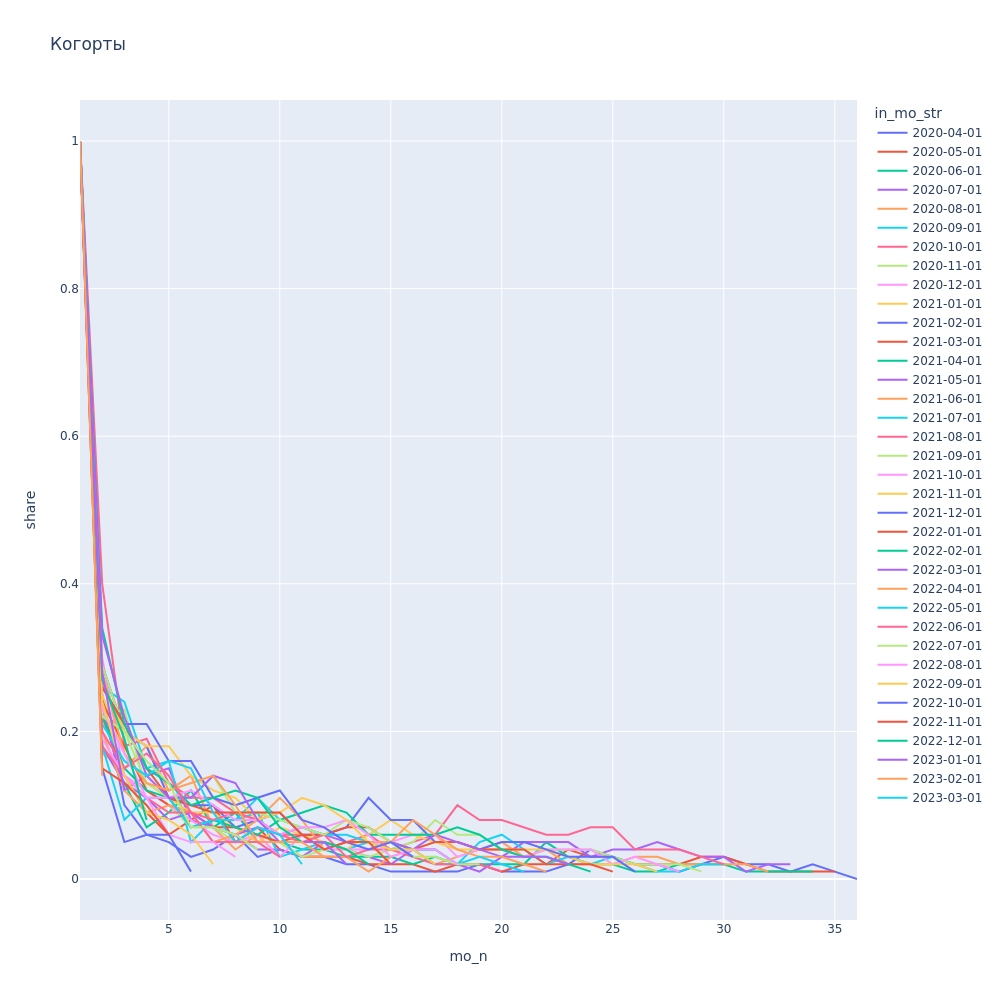

In [4]:
for i in ['action', 'actor']:
    if i in message.columns:
        message = message.drop(columns=[i])

message['mo'] = message['mo'] = message.date.astype('datetime64[M]')
message['day'] = message.date.astype('datetime64[D]')
message['week'] = message.date.astype('datetime64[W]')

message['in_mo'] = message.groupby('from_id').mo.transform('min')
message['coh_size'] = message.groupby('in_mo').from_id.transform('nunique')

df_res = message.groupby(['mo', 'in_mo', 'coh_size'], as_index=False)\
    .agg(nunq = ('from_id','nunique'), mes_cnt = ('from_id','count'))

df_res = df_res.sort_values(['in_mo', 'mo']).rename(columns={'nunq': 'coh_mo_cnt'})
df_res['share'] = (df_res.coh_mo_cnt / df_res.coh_size).round(2)
df_res['mo_n'] = df_res.groupby(['in_mo']).mo.rank(method='first').astype(int)
df_res['in_mo_str'] = df_res.in_mo.astype(str)
df_res['mo_cnt'] = df_res.groupby('in_mo').mo_n.transform('count')
df_res_all = df_res.copy()
# df_res = df_res.query('mo_cnt > 5 and mo_n < 7')

import plotly.express as px
fig = px.line(df_res, x='mo_n', y='share', color='in_mo_str', title='Когорты')
# fig.write_html(f'N://Cohort analysis.html')
fig

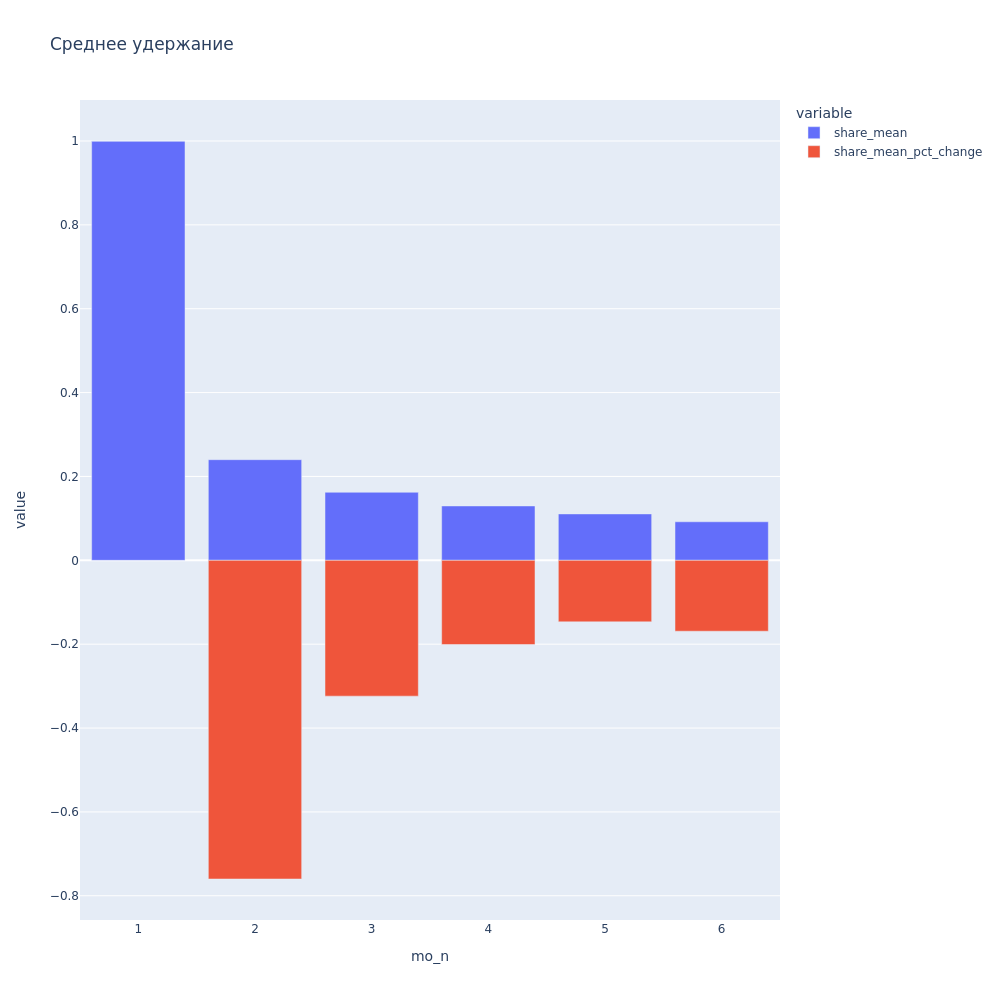

In [5]:
import pandas as pd; import numpy as np
# Step: Group by mo_n and calculate new column(s)
df_res_mean = df_res.query('mo_cnt > 5 and mo_n < 7').groupby(['mo_n']).agg(share_mean=('share', 'mean')).reset_index()

import pandas as pd; import numpy as np
# Step: Percentage change
df_res_mean['share_mean_pct_change'] = df_res_mean['share_mean'].transform('pct_change')

df_res_mean = df_res_mean.fillna(0)
import plotly.express as px
fig = px.bar(df_res_mean, x='mo_n', y=['share_mean', 'share_mean_pct_change'], title='Среднее удержание')
fig

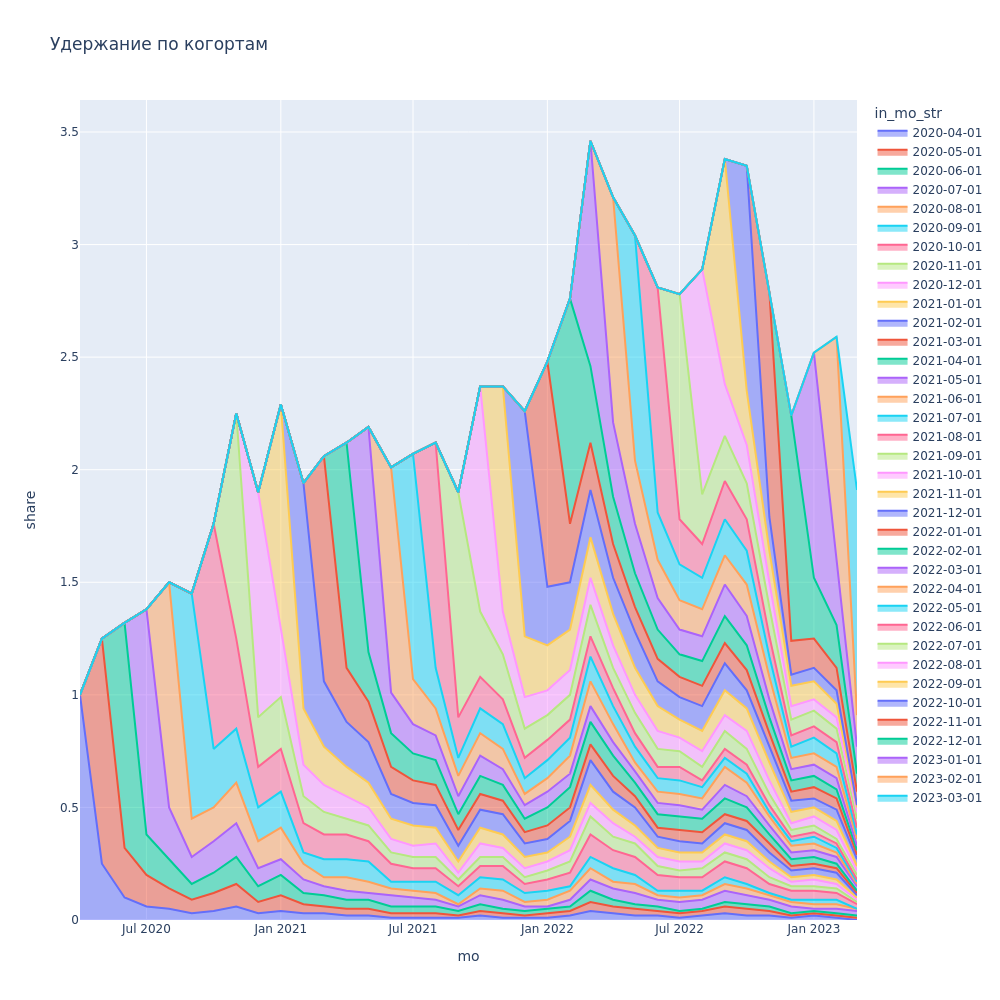

In [6]:
import plotly.express as px
fig = px.area(df_res, x='mo', y='share', color='in_mo_str', title='Удержание по когортам')
fig

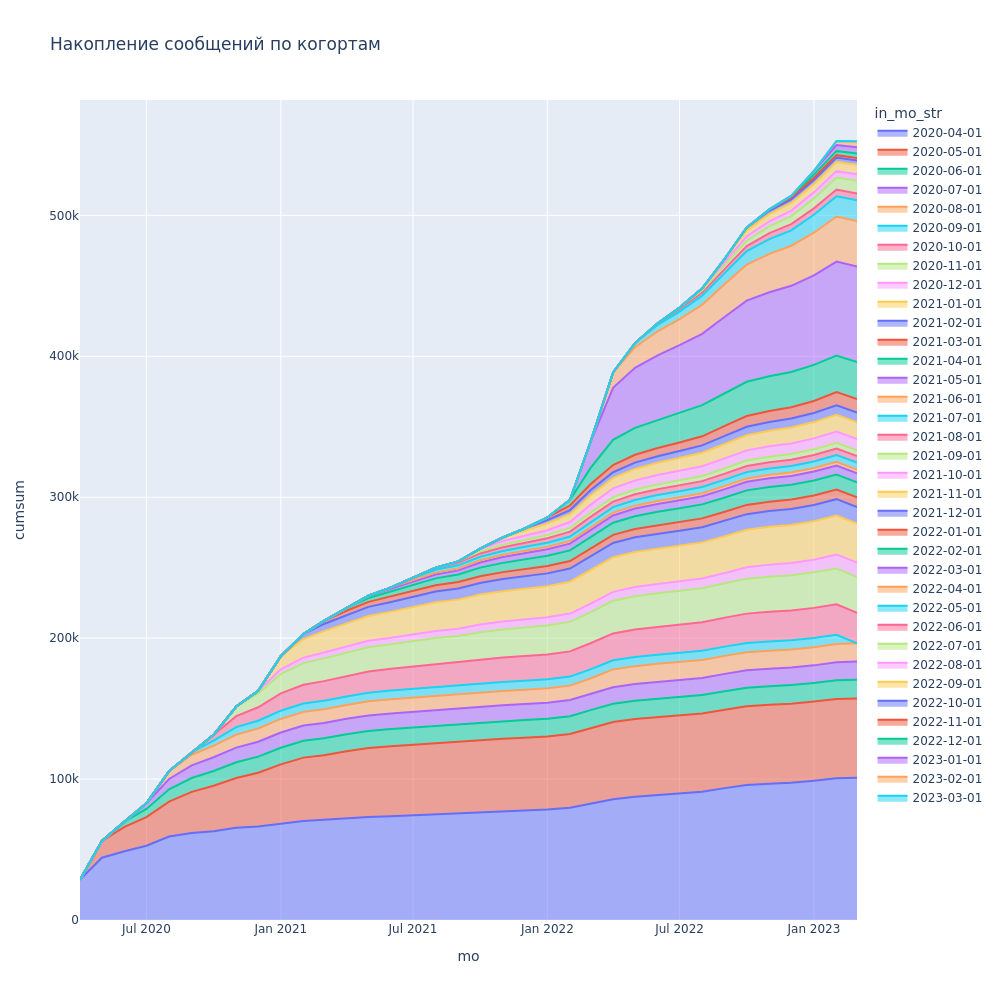

In [7]:
df_res_all['cumsum'] = df_res.groupby('in_mo').mes_cnt.transform('cumsum')
import plotly.express as px
fig = px.area(df_res_all, x='mo', y='cumsum', color='in_mo_str', title='Накопление сообщений по когортам')
fig

### DAU, WAU, MAU, Sticky Factor

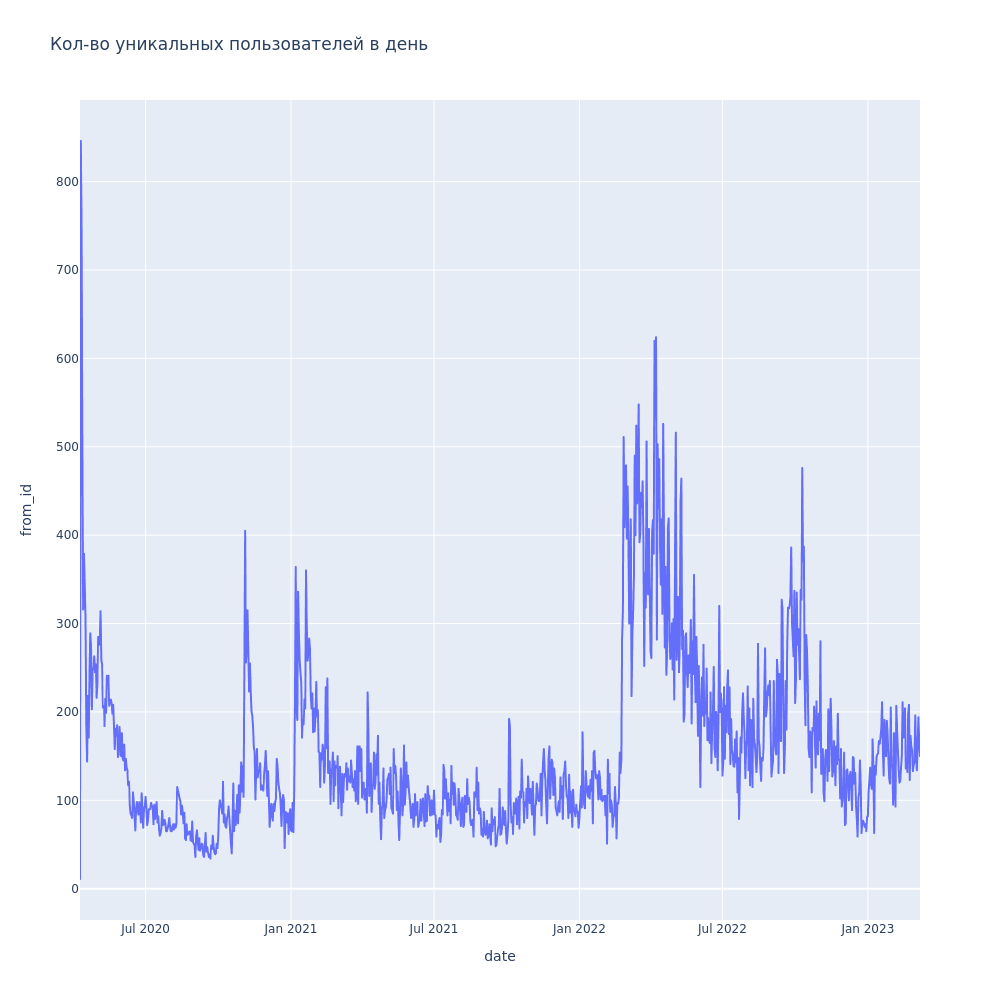

In [8]:
# Кол-во уникальных пользователей в день
import pandas as pd; import numpy as np
# Step: Change datetime frequency
mes_dau = message.set_index('date').resample('1D').nunique().reset_index()

import plotly.express as px
fig = px.line(mes_dau.sort_values(by=['date'], ascending=[True]), x='date', y='from_id',\
              title='Кол-во уникальных пользователей в день')
fig

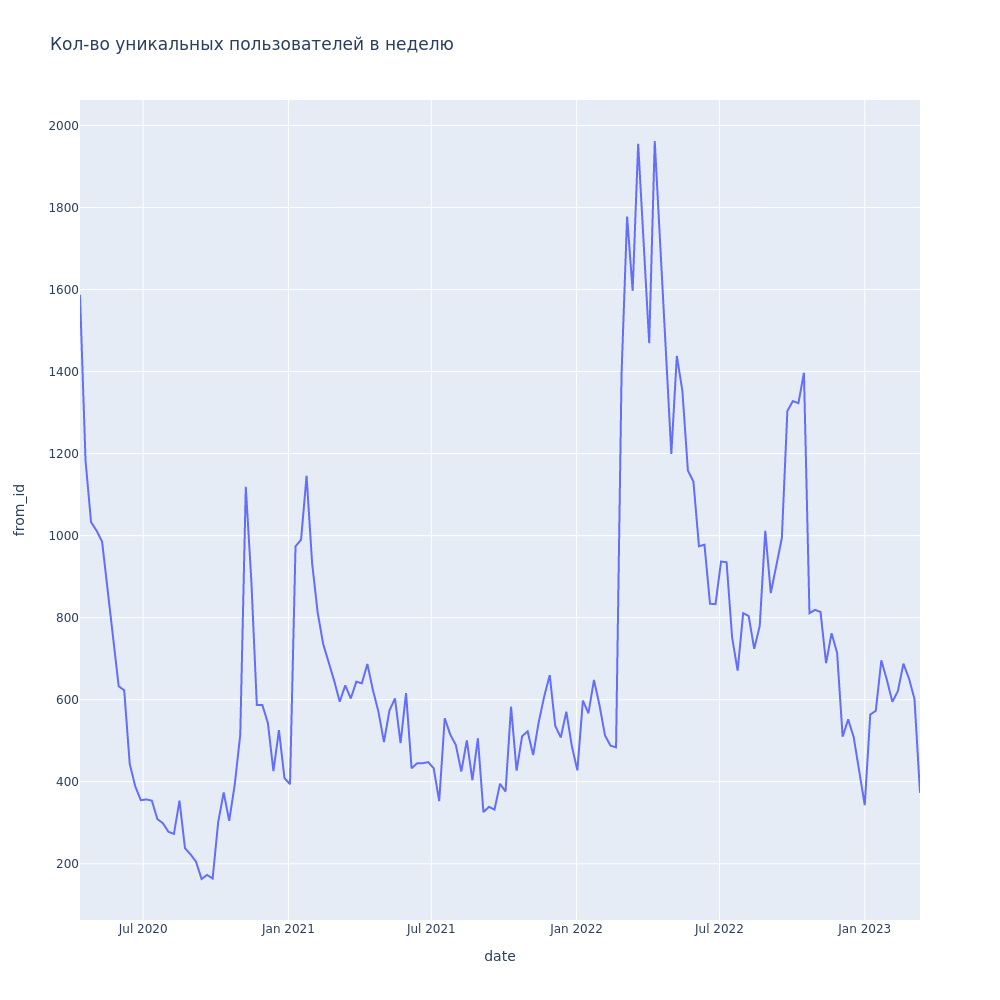

In [9]:
# Кол-во уникальных пользователей в неделю
import pandas as pd; import numpy as np
# Step: Change datetime frequency
mes_wau = message.set_index('date').resample('W').nunique().reset_index()

import plotly.express as px
fig = px.line(mes_wau.sort_values(by=['date'], ascending=[True]), x='date', y='from_id',\
              title='Кол-во уникальных пользователей в неделю')
fig

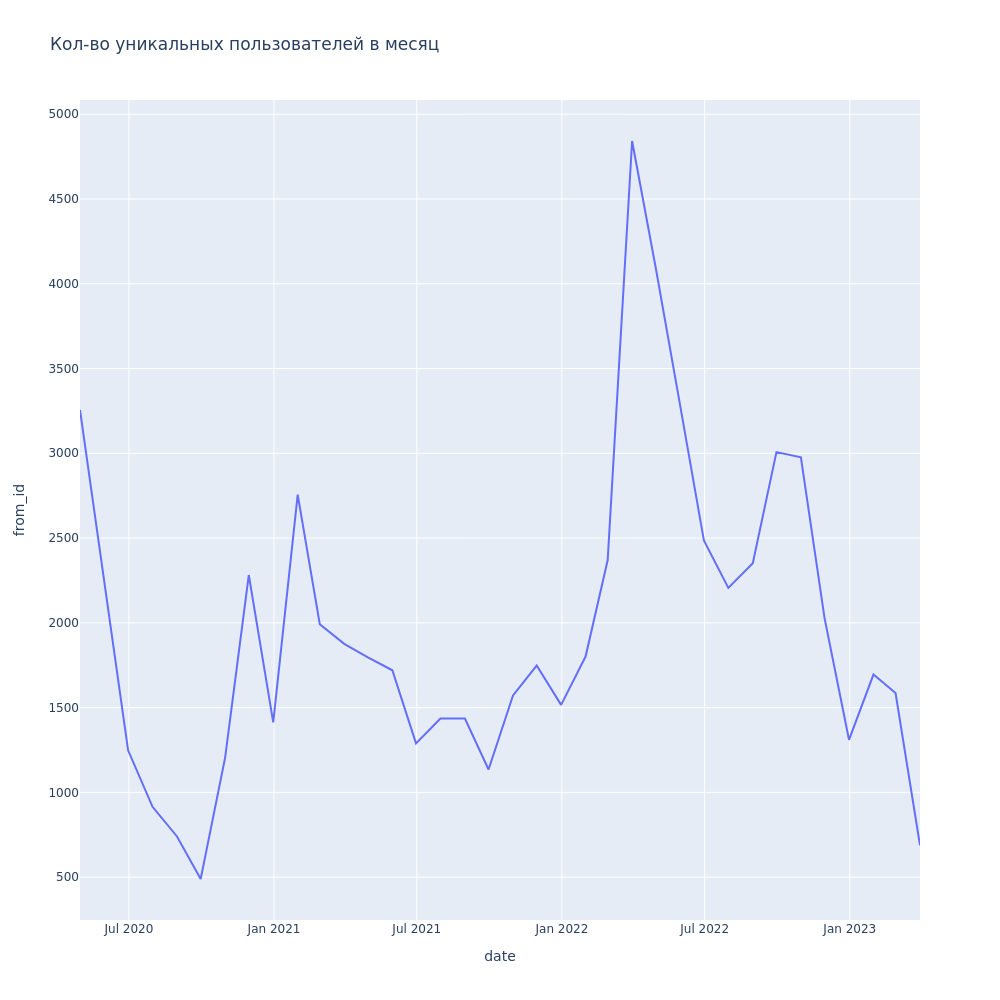

In [10]:
# Кол-во уникальных пользователей в месяц
import pandas as pd; import numpy as np
# Step: Change datetime frequency
mes_mau = message.set_index('date').resample('1M').nunique().reset_index()

import plotly.express as px
fig = px.line(mes_mau.sort_values(by=['date'], ascending=[True]), x='date', y='from_id',\
              title='Кол-во уникальных пользователей в месяц')
fig

#### Sticky Factor

In [11]:
import pandas as pd; import numpy as np
# Step: Select columns
mess_dwm = message[['from_id', 'day', 'week', 'mo']]

mess_dwm['dau'] = mess_dwm.groupby('day').from_id.transform('nunique')
mess_dwm['wau'] = mess_dwm.groupby('week').from_id.transform('nunique')
mess_dwm['mau'] = mess_dwm.groupby('mo').from_id.transform('nunique')
mess_dwm['sf_dw'] = mess_dwm.dau / mess_dwm.wau
mess_dwm['sf_dm'] = mess_dwm.dau / mess_dwm.mau
mess_dwm['sf_wm'] = mess_dwm.wau / mess_dwm.mau

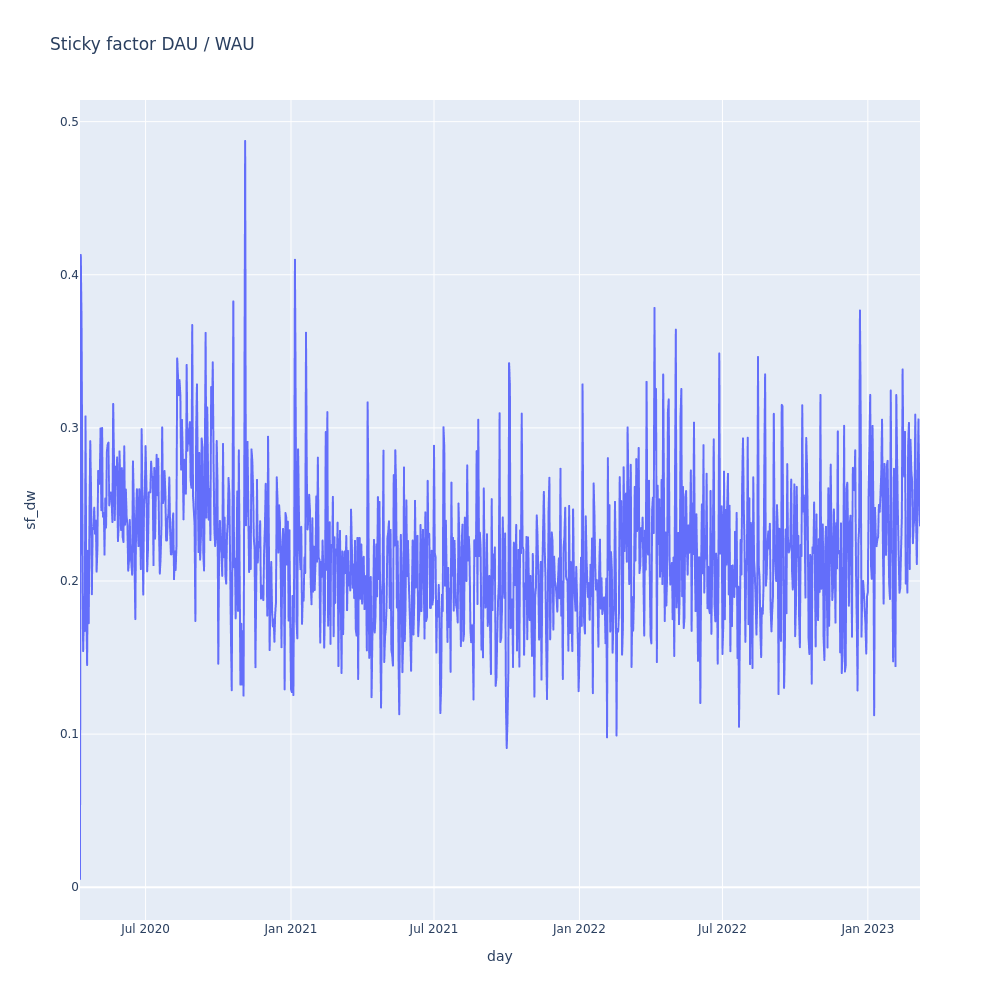

In [12]:
import pandas as pd; import numpy as np
# Step: Select columns
mess_dw = mess_dwm[['day', 'sf_dw']]

# Step: Drop duplicates based on ['day', 'week', 'sf_dw']
mess_dw = mess_dw.drop_duplicates(keep='first')

import plotly.express as px
fig = px.line(mess_dw.sort_values(by=['day'], ascending=[True]), x='day', y='sf_dw', title='Sticky factor DAU / WAU')
fig

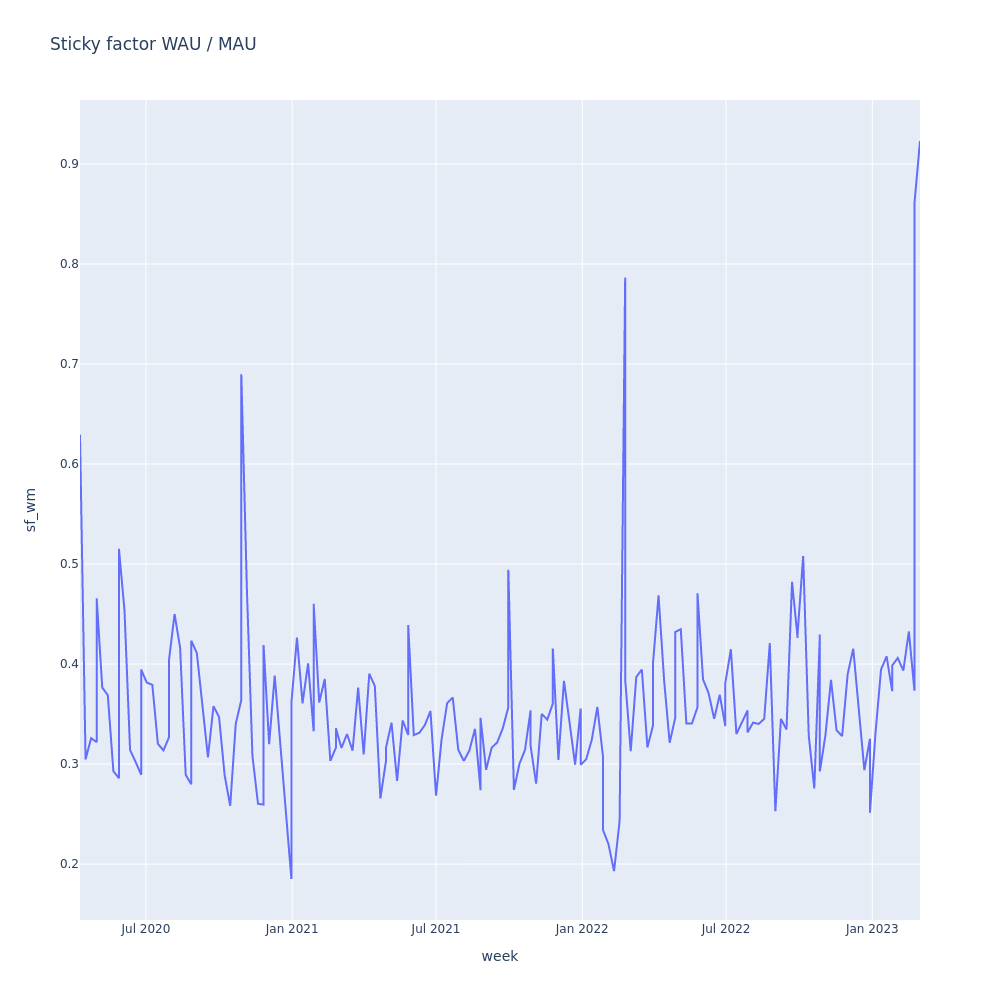

In [13]:
import pandas as pd; import numpy as np
# Step: Select columns
mess_wm = mess_dwm[['week', 'sf_wm']]

# Step: Drop duplicates based on ['day', 'week', 'sf_dw']
mess_wm = mess_wm.drop_duplicates(keep='first')

import plotly.express as px
fig = px.line(mess_wm.sort_values(by=['week'], ascending=[True]), x='week', y='sf_wm', title='Sticky factor WAU / MAU')
fig

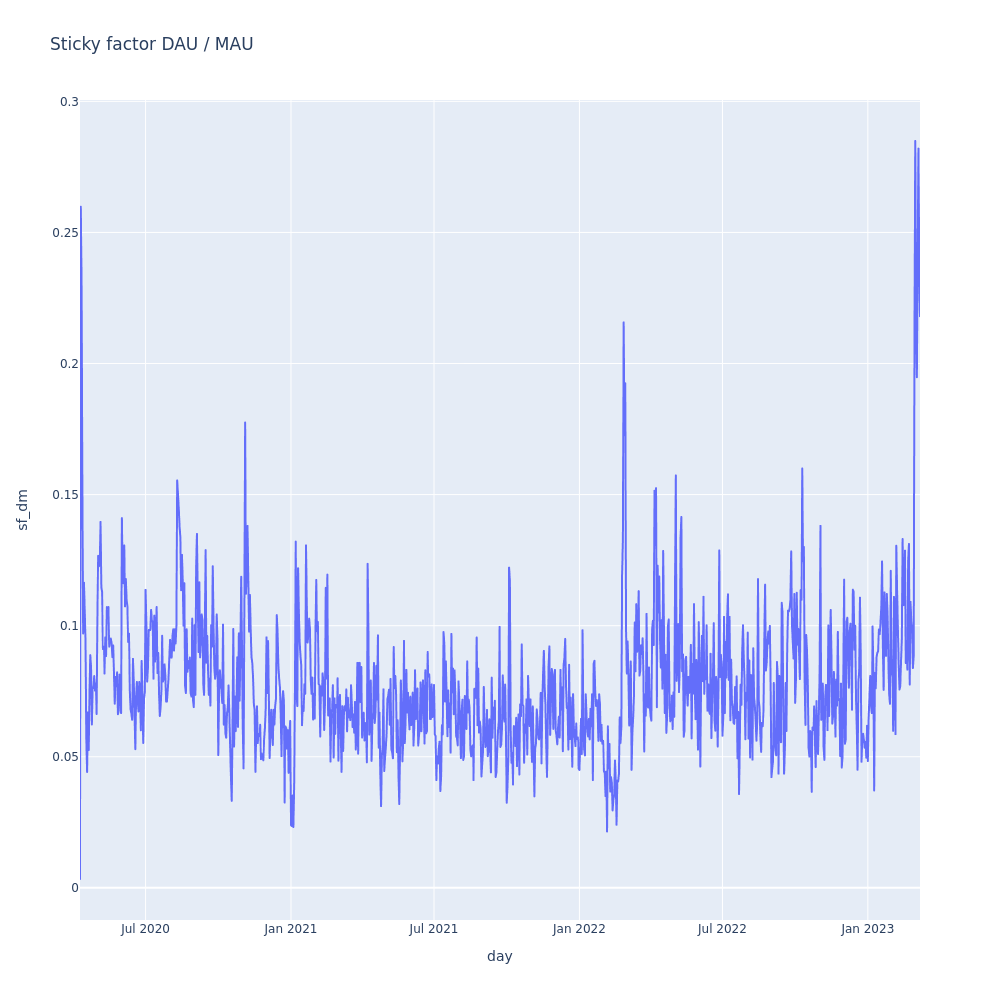

In [14]:
import pandas as pd; import numpy as np
# Step: Select columns
mess_dm = mess_dwm[['day', 'sf_dm']]

# Step: Drop duplicates based on ['day', 'sf_dw']
mess_dm = mess_dm.drop_duplicates(keep='first')

import plotly.express as px
fig = px.line(mess_dm.sort_values(by=['day'], ascending=[True]), x='day', y='sf_dm', title='Sticky factor DAU / MAU')
fig

### **Вывод**

* Данные представлены с апреля 2020 года по март 2023 года
* Архив содержит 537,318 записей о совершенных действиях
* Кол-во приглашенных за отчетный период – 32,494
* Кол-во когорт – 31
* Период анализа когорт – 6 месяцев
* Средний уровень удержания на второй месяц оставляет 31,6%
* Все когорты имеют тенденцию снижения на второй месяц, некоторые - с небольшими всплесками уровня удержания порядка 2-5% в последующие месяцы
* Лучшая когорта с удержанием 52% на второй месяц стартовала в феврале 2022, худшая – с удержанием 16% - в августе 2020 года
* Имеются несколько когорт, наращивающие свое присутствие после второго месяца. Это: 2020-08, 2020-07, 2021-08, 2021-10, 2021-11, 2021-12, 2022-05, 2022-09, 2022-10
* Кумулятивный пик кол-ва сообщений когорт находится в сентябре 2020 и составляет порядка 102,000


## Количественный анализ

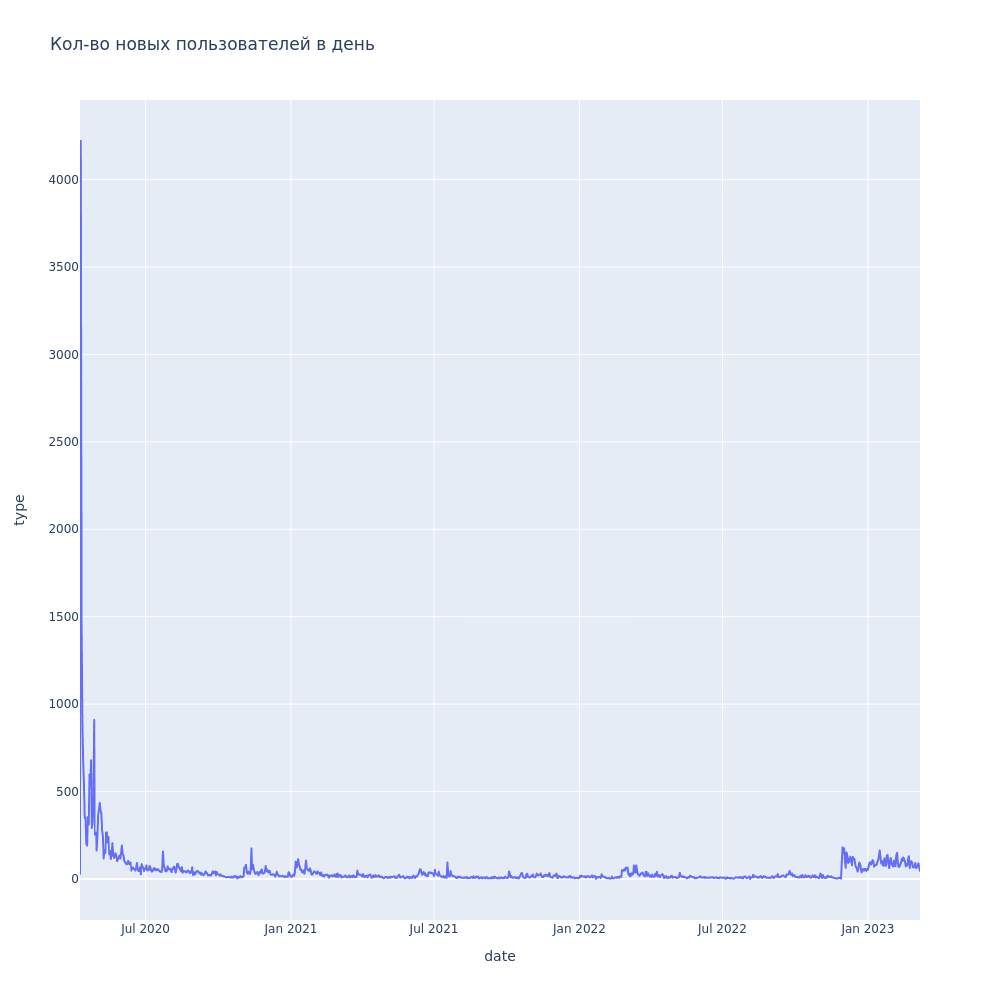

In [15]:
import pandas as pd; import numpy as np
# Step: Keep rows where action is one of: invite_members, join_group_by_link
service = service.loc[service['action'].isin(['invite_members', 'join_group_by_link'])]

# Step: Change datetime frequency
service_day = service.set_index('date').resample('1D').count().reset_index()

import plotly.express as px
fig = px.line(service_day.sort_values(by=['date'], ascending=[True]), x='date', y='type', title='Кол-во новых пользователей в день')
fig

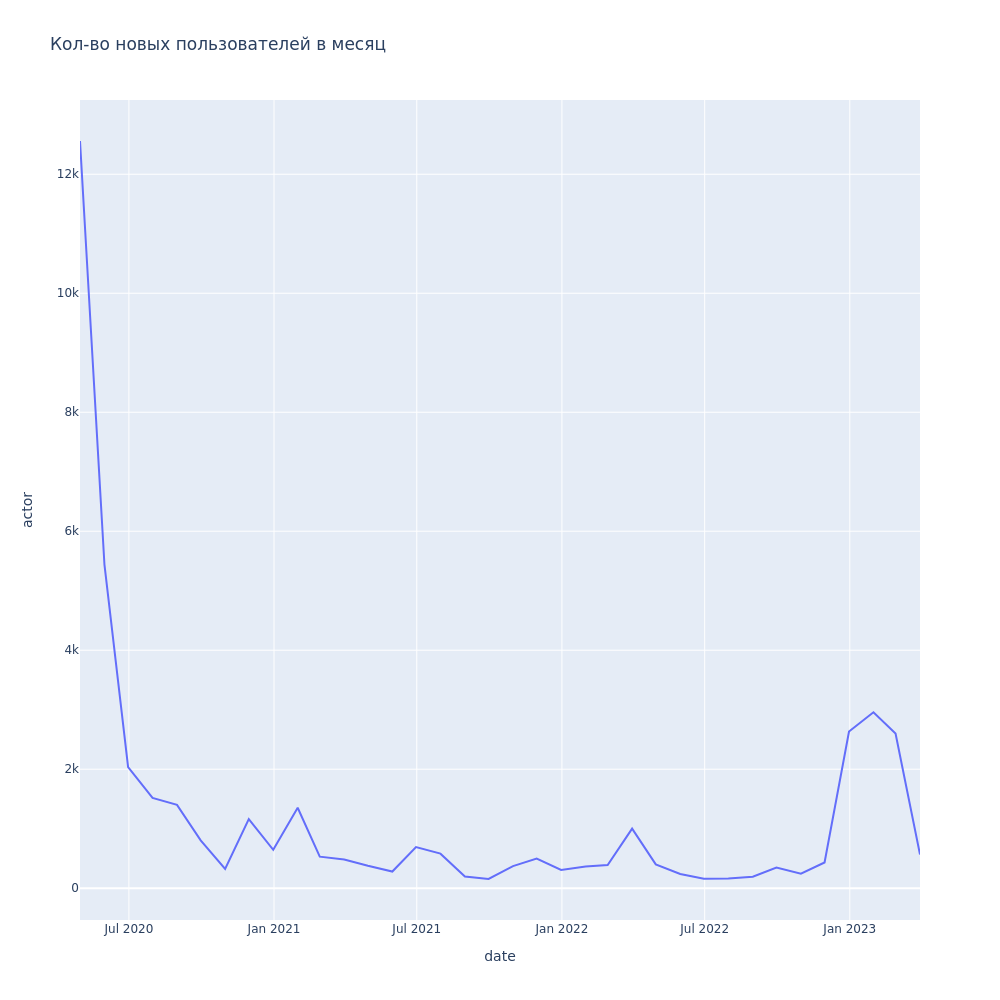

In [16]:
import pandas as pd; import numpy as np
# Step: Change datetime frequency
service_mo = service.set_index('date').resample('1M').count().reset_index()

import plotly.express as px
fig = px.line(service_mo.sort_values(by=['date'], ascending=[True]), x='date', y='actor', title='Кол-во новых пользователей в месяц')
fig

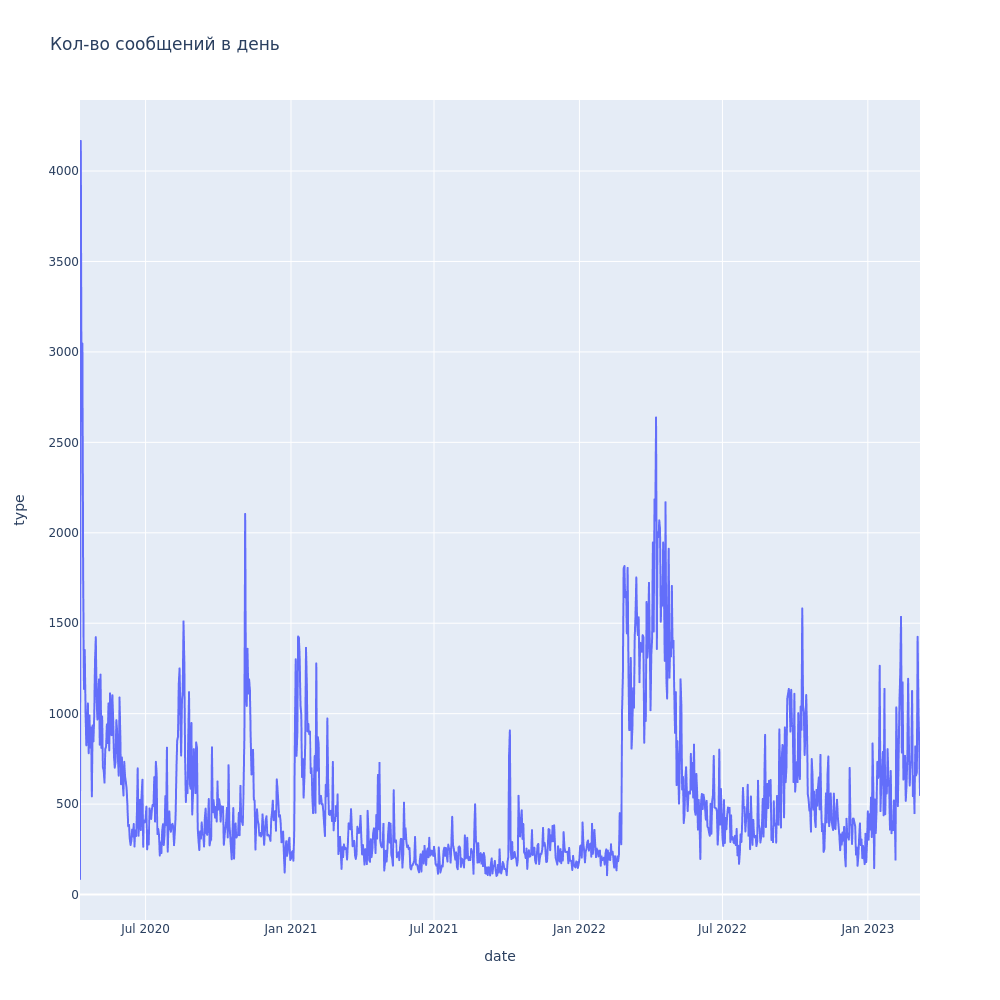

In [17]:
# Кол-во сообщений в день
import pandas as pd; import numpy as np
# Step: Change datetime frequency
message_day_cnt = message.set_index('date').resample('1D').count().reset_index()

import plotly.express as px
fig = px.line(message_day_cnt.sort_values(by=['date'], ascending=[True]), x='date', y='type', title='Кол-во сообщений в день')
fig

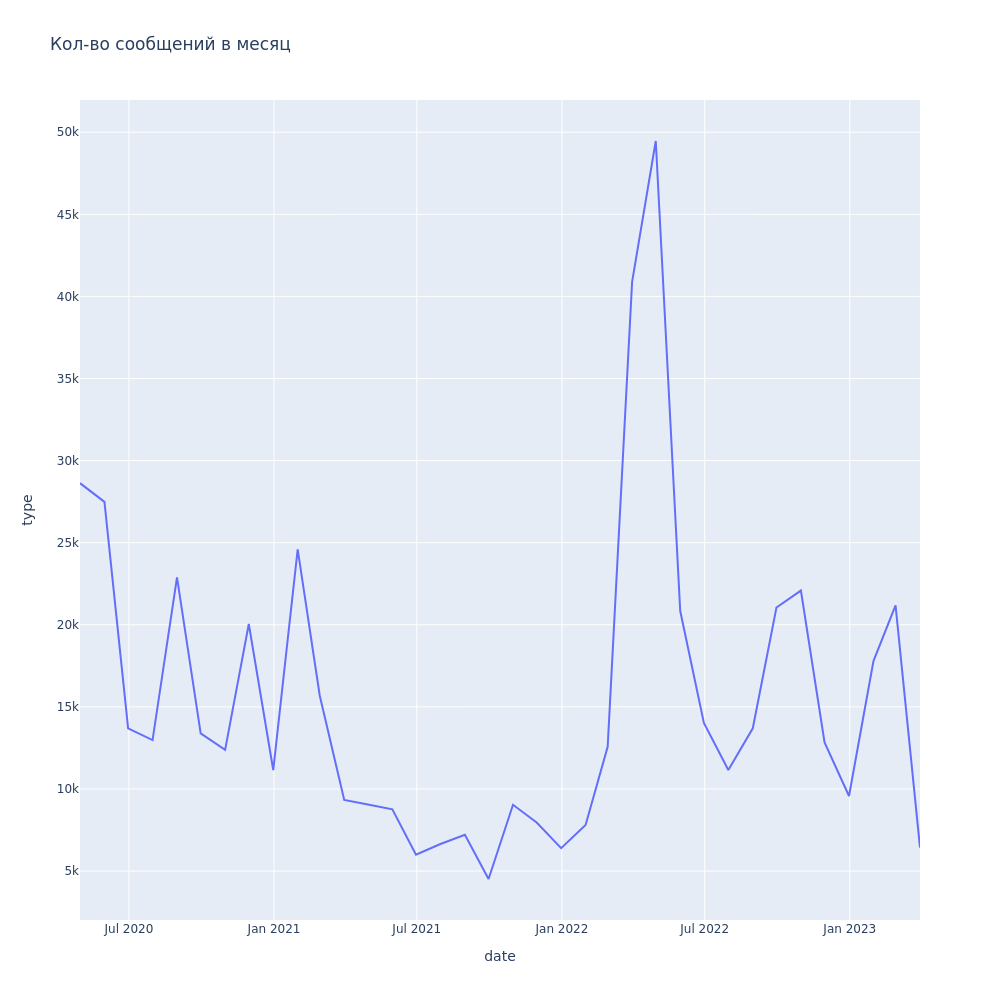

In [18]:
# Кол-во сообщений в месяц
import pandas as pd; import numpy as np
# Step: Change datetime frequency
message_day_cnt = message.set_index('date').resample('1M').count().reset_index()

import plotly.express as px
fig = px.line(message_day_cnt.sort_values(by=['date'], ascending=[True]), x='date', y='type', title='Кол-во сообщений в месяц')
fig

In [19]:
# Step: Drop columns
for i in ['action', 'actor']:
    if i in message.columns:
        message = message.drop(columns=[i])
# message = message.drop(columns=['action', 'actor'])

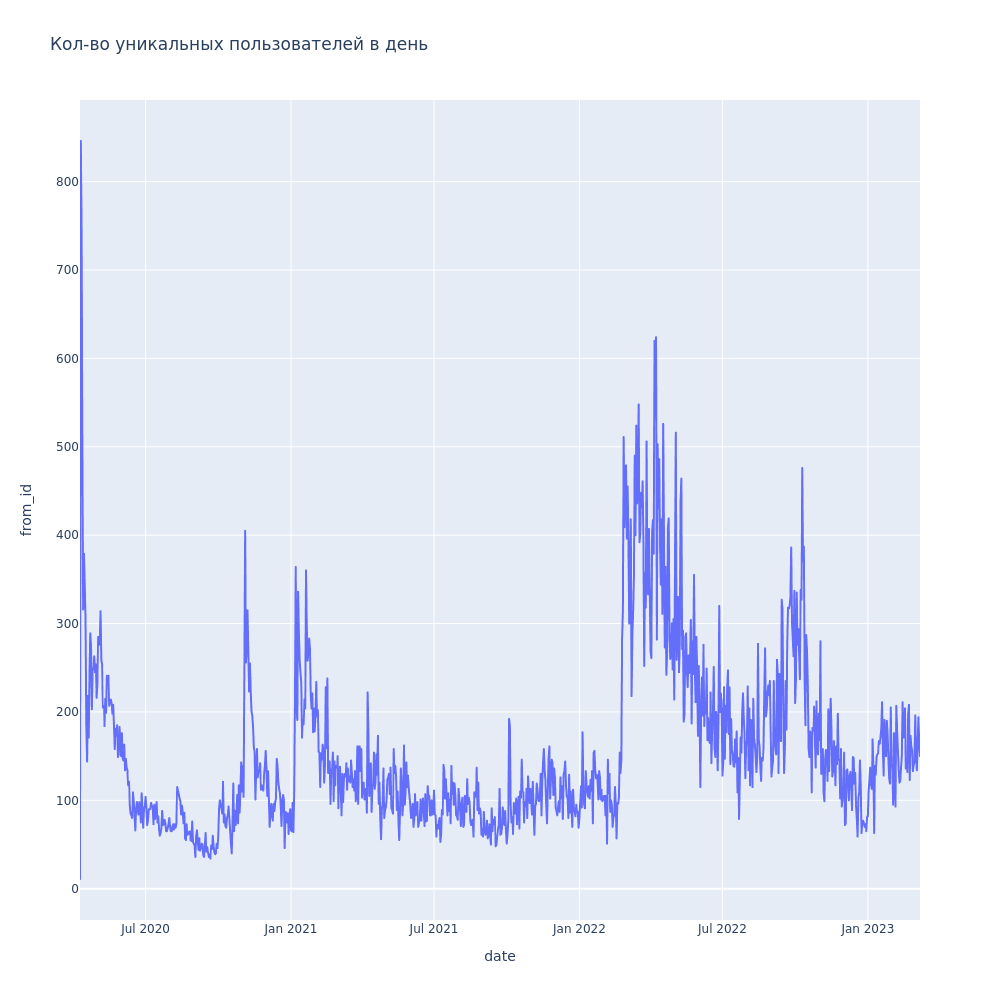

In [20]:
# Кол-во уникальных пользователей в день
import pandas as pd; import numpy as np
# Step: Change datetime frequency
acive_users_day_cnt = message.set_index('date').resample('1D').nunique().reset_index()

import plotly.express as px
fig = px.line(acive_users_day_cnt.sort_values(by=['date'], ascending=[True]), x='date', y='from_id', title='Кол-во уникальных пользователей в день')
fig

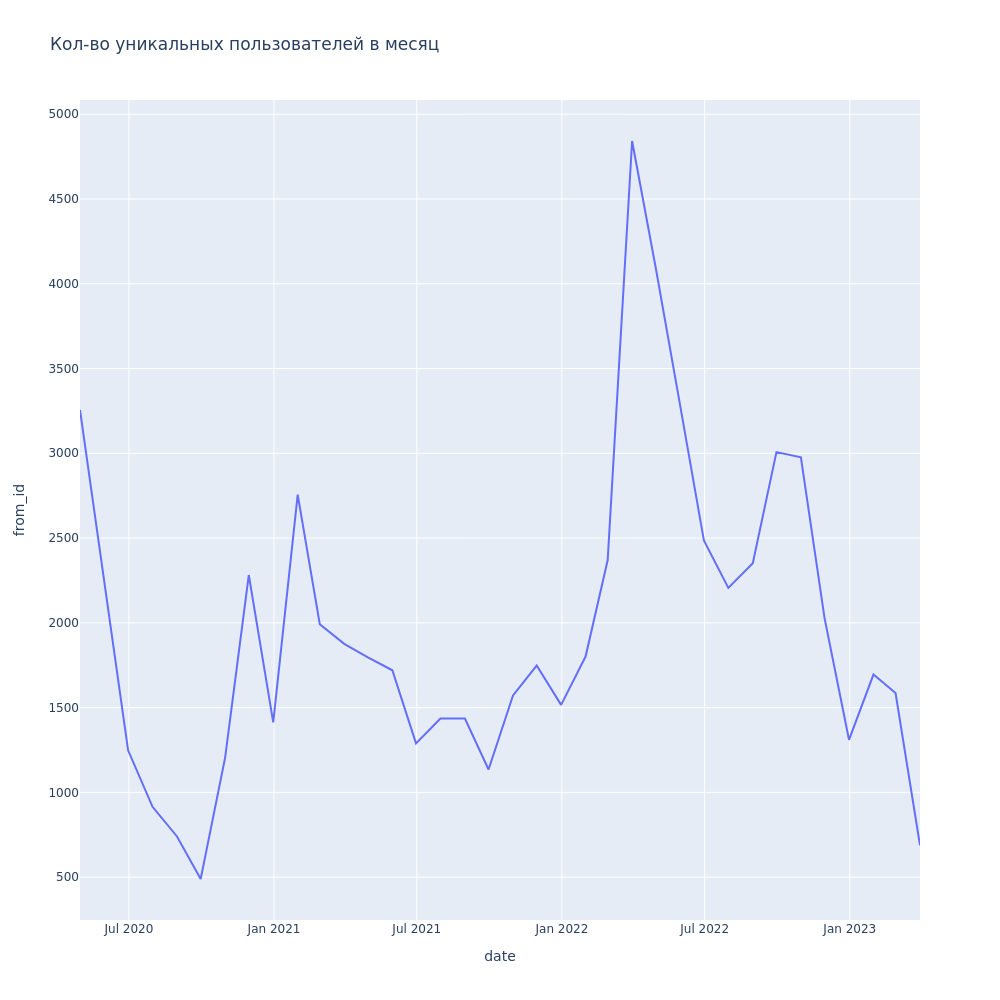

In [21]:
# Кол-во уникальных пользователей в месяц
import pandas as pd; import numpy as np
# Step: Change datetime frequency
acive_users_mo_cnt = message.set_index('date').resample('1M').nunique().reset_index()

import plotly.express as px
fig = px.line(acive_users_mo_cnt.sort_values(by=['date'], ascending=[True]), x='date', y='from_id', title='Кол-во уникальных пользователей в месяц')
fig

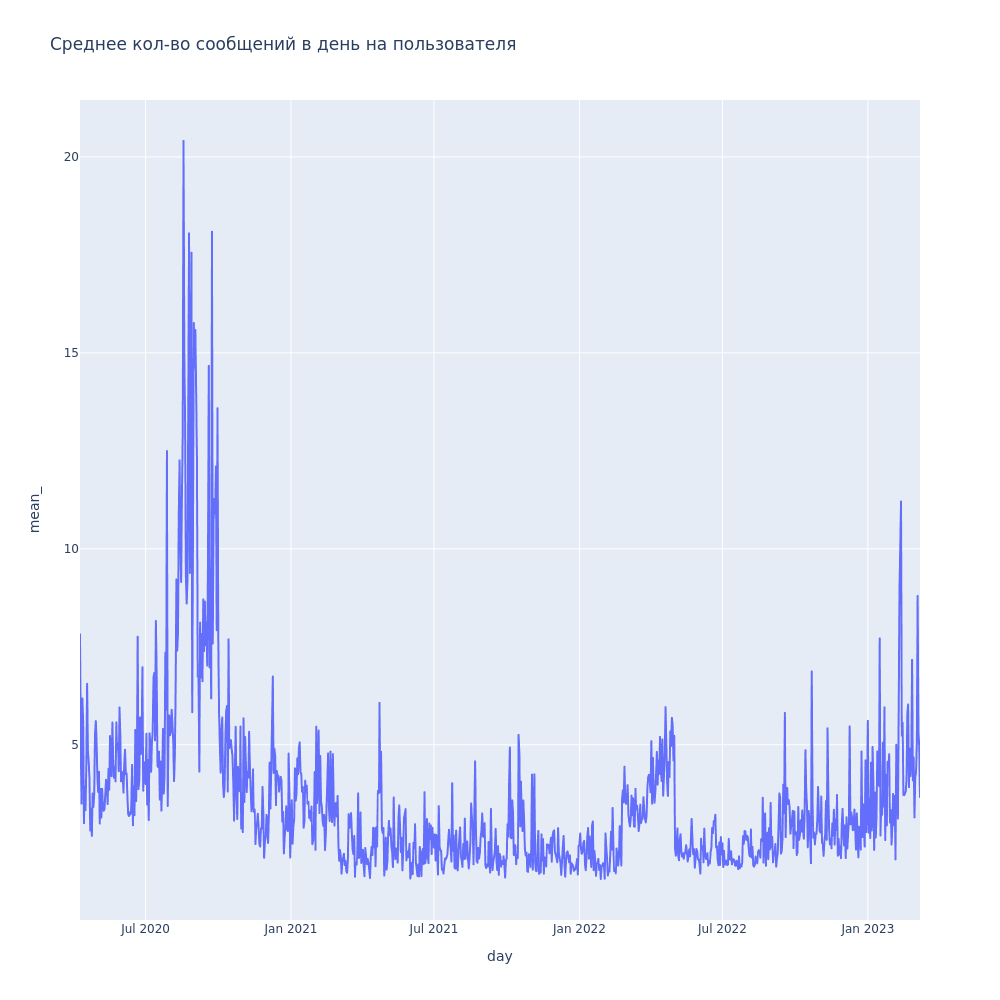

In [22]:
# Среднее кол-во сообщений на пользователя в день
import pandas as pd; import numpy as np
# Step: Group by and aggregate
message_mean_by_user_daily = message.groupby(['day']).agg(from_id_nunique=('from_id', 'nunique'),\
                            type_size=('type', 'size')).reset_index()

import pandas as pd; import numpy as np
# Step: Rename column
message_mean_by_user_daily = message_mean_by_user_daily.rename(columns={'from_id_nunique': 'unique_users_cnt'})

# Step: Rename column
message_mean_by_user_daily = message_mean_by_user_daily.rename(columns={'type_size': 'mes_cnt'})

message_mean_by_user_daily['mean_'] = message_mean_by_user_daily.mes_cnt / message_mean_by_user_daily.unique_users_cnt

import plotly.express as px
fig = px.line(message_mean_by_user_daily.sort_values(by=['day'], ascending=[True]), x='day', y='mean_',\
              title='Среднее кол-во сообщений в день на пользователя')
fig

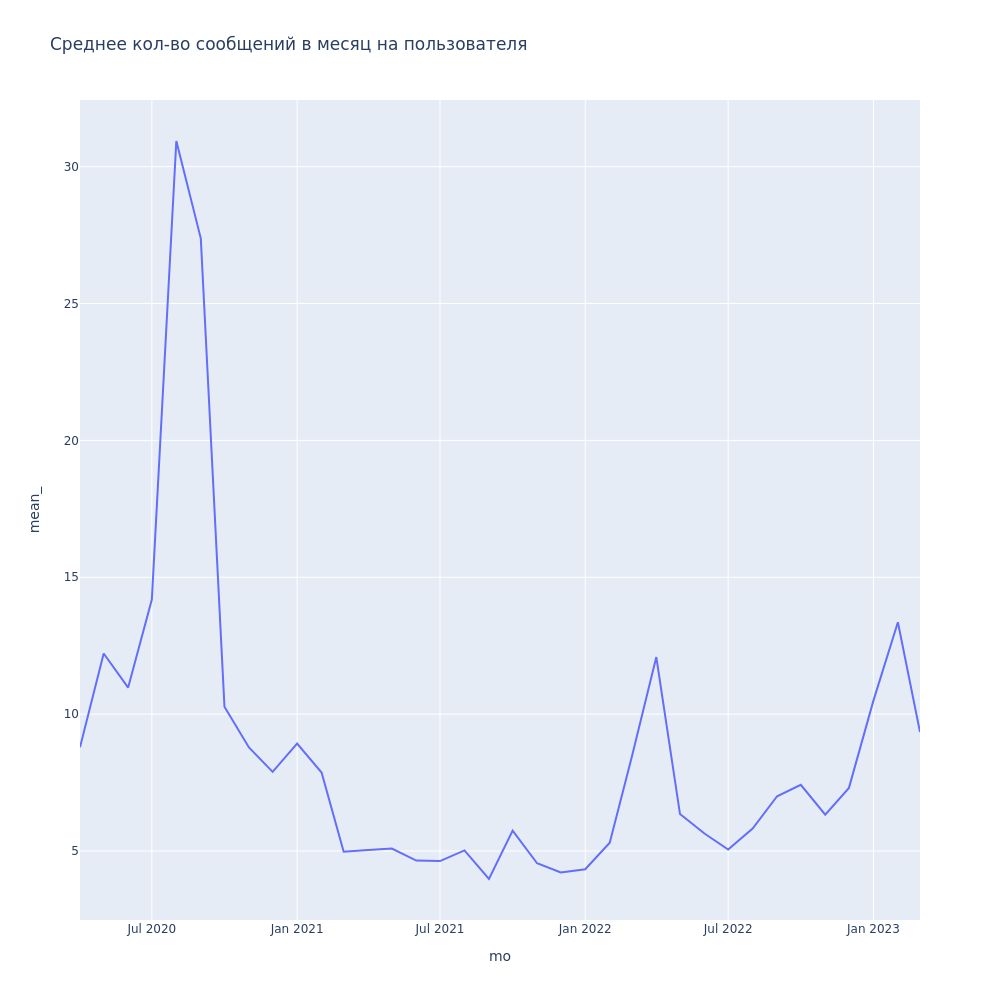

In [23]:
# Среднее кол-во сообщений на пользователя в месяц

import pandas as pd; import numpy as np
# Step: Group by and aggregate
message_mean_by_user_mo = message.groupby(['mo']).agg(from_id_nunique=('from_id', 'nunique'), type_size=('type', 'size')).reset_index()

import pandas as pd; import numpy as np
# Step: Rename column
message_mean_by_user_mo = message_mean_by_user_mo.rename(columns={'from_id_nunique': 'unique_users_cnt'})

# Step: Rename column
message_mean_by_user_mo = message_mean_by_user_mo.rename(columns={'type_size': 'mes_cnt'})

message_mean_by_user_mo['mean_'] = message_mean_by_user_mo.mes_cnt / message_mean_by_user_mo.unique_users_cnt

import plotly.express as px
fig = px.line(message_mean_by_user_mo.sort_values(by=['mo'], ascending=[True]), x='mo', y='mean_',\
              title='Среднее кол-во сообщений в месяц на пользователя')
fig

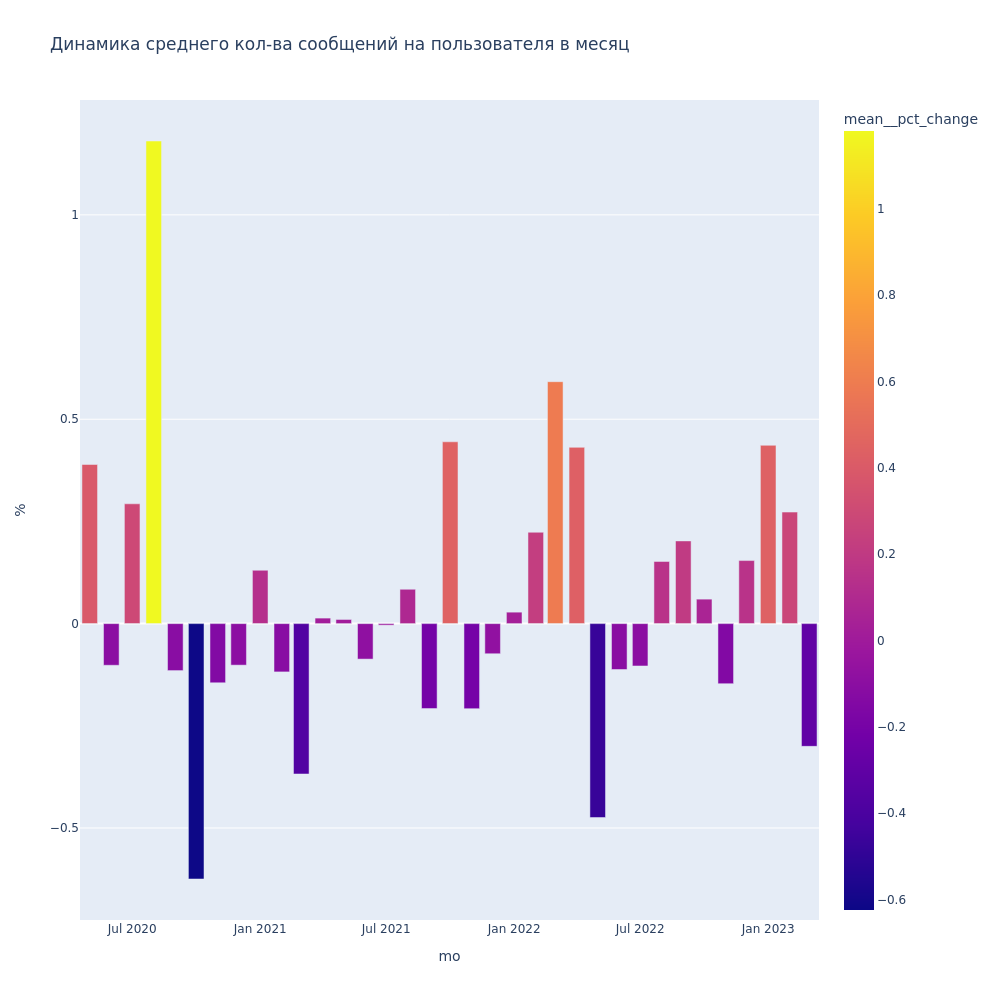

In [24]:
import pandas as pd; import numpy as np
# Step: Percentage change
message_mean_by_user_mo['mean__pct_change'] = message_mean_by_user_mo['mean_'].transform('pct_change')

import plotly.express as px
fig = px.bar(message_mean_by_user_mo.dropna(subset=['mean__pct_change']), x='mo', y='mean__pct_change',\
             color='mean__pct_change', title='Динамика среднего кол-ва сообщений на пользователя в месяц')
fig.update_yaxes(title_text='%')
fig

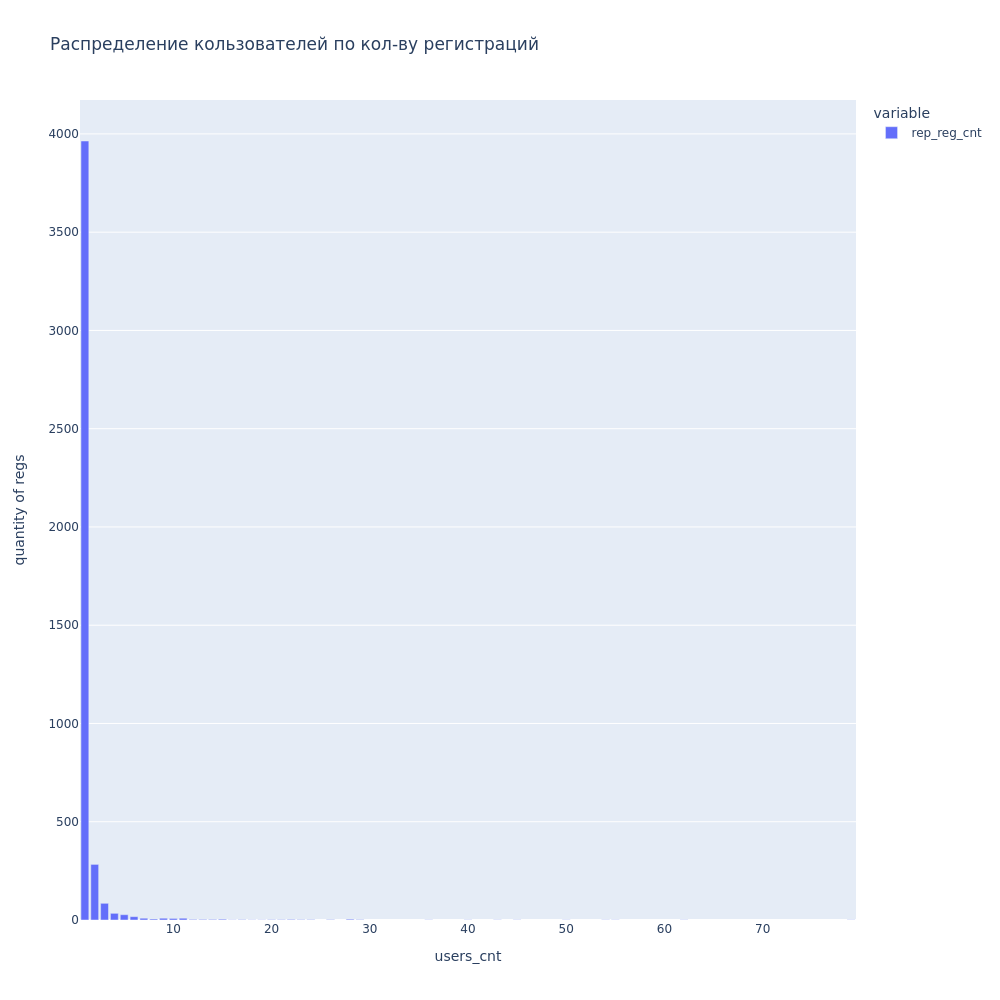

In [25]:
# распределение кол-ва регистраций по пользователям
service_users_rep_reg = service.query('action == "join_group_by_link"').groupby('actor', as_index=False).action.count()
import pandas as pd; import numpy as np
# Step: Rename column
service_users_rep_reg = service_users_rep_reg.rename(columns={'action': 'rep_reg_cnt'})

df_ = pd.DataFrame(service_users_rep_reg.rep_reg_cnt.value_counts())
import plotly.express as px
fig = px.bar(df_, title='Распределение кользователей по кол-ву регистраций')
fig.update_xaxes(title_text='users_cnt')
fig.update_yaxes(title_text='quantity of regs')
fig

### **Вывод**

* Среднее кол-во привлеченных пользователей составляет 377 в месяц, максимальное 2640 (2020-04), минимальное – 110 (2021-09)
Максимальный прирост кол-ва пользователей составляет 152% к предыдущему (2022-03), минимальный - -60% (2023-03). Средний прирост составляет 0% - активность группы стагнирует
Максимальное число активных пользователей – 2640 (2020-04), минимальное – 430 (2020-09), среднее – 1109

* Максимальное число сообщений – 28527 (2022-04), минимальное – 2607 (2021-09-01), среднее – 10884

* Максимальный прирост кол-ва сообщений составляет 222% к предыдущему (2022-03), минимальный - -62% (2022-05). Средний прирост составляет 0% - активность группы стагнирует
Кол-во сообщений в день по скользящему среднему за 7 дней составляет максимальное 1927 (2020-04), минимальное – 57 (2021-09), среднее – 361

* Максимальное кол-во сообщений в день на пользователя по скользящему среднему за 7 дней составляет 15 (2020-08), минимальное 1,67 (2020-08), среднее – 4

* Максимальное кол-во сообщений в месяц на пользователя составляет 31.79 (2020-08), минимальное 4.68 (2022-01), среднее – 10

* Максимальный прирост среднего кол-ва сообщений в месяц на пользователя составляет 117% к предыдущему (2020-08), минимальный - -56% (2022-05). Средний прирост составляет 0% - активность группы стагнирует


## Анализ совместной активности пользователей


`Возьмем один месяц для примера` - март 2022, для анализа исключим пользователей, которые зарегистрировалис в этом месяце.

Эти пользователи не имеют user_id


In [26]:
start = time.time()

freq = 'D'

df['mo'] = df.date.astype('datetime64[M]')
# df_reg_mo = df.query('mo == "2022-03-01"')
# df_reg_mo = df.query('mo == "2020-12-01"')
df_reg_mo = df.query('mo == "2020-09-01"')
# df_reg_mo = df.query('mo == "2020-11-01"')

import pandas as pd; import numpy as np
# Step: Keep rows where from_id is not missing
df_reg_mo = df_reg_mo.loc[df_reg_mo['from_id'].notna()]

# Step: Select columns
df_mo = df_reg_mo[['from_id', 'date', 'text']]
# df_mo.date = df_mo.date.to_numpy().astype(f'datetime64[{freq}]')

df_full = df_mo.groupby(['from_id', 'date'], as_index=False).text.count()

start_date = df_mo.date.min().replace(day=1, hour=0, minute=0, second=0)
end_date = (df_full.date.max() + pd.DateOffset(months=1)).replace(hour=23, minute=59, second=59)
    
bins = (pd.date_range(start_date, end_date, freq=freq))

df_full['bin'] = pd.cut(df_full.date, bins)

import pandas as pd; import numpy as np
# Step: Change data type of bin to String/Text
df_full['bin'] = df_full['bin'].astype('string')

def to_date(col):
    return col.split(',')[0][1:]

df_full.bin = df_full.bin.swifter.apply(to_date)

df_full
import pandas as pd; import numpy as np
# Step: Change data type of bin to Datetime
df_full['bin'] = pd.to_datetime(df_full['bin'], format='%Y-%m-%d %H:%M:%S')

df_bins = pd.DataFrame(bins)

import pandas as pd; import numpy as np
df_bins.columns = [str(column) for column in df_bins.columns]
# Step: Rename column
df_bins = df_bins.rename(columns={'0': 'bin'})

df_full = pd.concat([df_full, df_bins])

df_p = pd.pivot_table(df_full, index='bin', columns='from_id', values='text')
df_p = df_p.fillna(0)

dfpc = pd.DataFrame(np.corrcoef(df_p.values, rowvar=False).round(5))
dfpc.columns, dfpc.index = df_p.columns, df_p.columns
dfpc = dfpc.rename_axis(None).rename_axis(None, axis=1)

uns = dfpc.unstack().reset_index()
import pandas as pd; import numpy as np
uns.columns = [str(column) for column in uns.columns]

uns = uns.rename(columns={'level_0': 'name1', 'level_1': 'name2', '0': 'corr_c'})
uns.corr_c = uns.corr_c.fillna(0)

uns = uns.query('name1 != name2')

import pandas as pd; import numpy as np
uns.columns = [str(column) for column in uns.columns]

import pandas as pd; import numpy as np
# Step: Change data type of name1 to String/Text
uns['name1'] = uns['name1'].astype('string')

# Step: Change data type of name2 to String/Text
uns['name2'] = uns['name2'].astype('string')
uns['nn'] = uns.name1 + ',' + uns.name2

def splt(col):
    return sorted(col.split(','))

uns.nn = uns.nn.swifter.apply(splt)

import pandas as pd; import numpy as np
# Step: Sort column(s) nn ascending (A-Z)
uns = uns.sort_values(by=['nn'], ascending=[True])

import pandas as pd; import numpy as np
# Step: Drop columns
uns = uns.drop(columns=['name1', 'name2'])

def n1(col):
    return col[0]
def n2(col):
    return col[1]

uns['name1'] = uns.nn.swifter.apply(n1)
uns['name2'] = uns.nn.swifter.apply(n2)
import pandas as pd; import numpy as np
# Step: Drop columns
uns = uns.drop(columns=['nn'])

uns = uns.drop_duplicates()
uns.corr_c = uns.corr_c.fillna(0)

uns_pos = uns.query('corr_c >= 0')
uns_pos['corr_cat'] = pd.cut(uns_pos.corr_c, np.arange(0, 1.1, 0.2)).cat.codes + 1
uns_neg = uns.query('corr_c < 0')
uns_neg['corr_cat'] = (pd.cut(uns_neg.corr_c*(-1), np.arange(0, 1.1, 0.2)).cat.codes + 1) * (-1)
uns_res = pd.concat([uns_neg, uns_pos], ignore_index=True)
import pandas as pd; import numpy as np
# Step: Sort column(s) corr_c ascending (A-Z)
uns_res = uns_res.sort_values(by=['name1'], ascending=[True])

uns_groups = uns_res.groupby('corr_cat', as_index=False).name1.count().rename(columns={'name1': 'cnt'})

uns_groups['freq'] = freq
uns_groups['share'] = (uns_groups.cnt / uns_groups.cnt.sum())#.round(2)

print(f'{freq}: {time.time() - start}')

uns_groups

Pandas Apply:   0%|          | 0/13330 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/238632 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/238632 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/238632 [00:00<?, ?it/s]

D: 2.342679500579834


    corr_cat    cnt freq     share
0         -5      9    D  0.000075
1         -4      8    D  0.000067
2         -3    219    D  0.001835
3         -2   2194    D  0.018388
4         -1  97664    D  0.818532
5          0    766    D  0.006420
6          1   7578    D  0.063512
7          2   4354    D  0.036491
8          3   3315    D  0.027783
9          4   1489    D  0.012479
10         5   1720    D  0.014416

In [27]:
uns_res

         corr_c              name1           name2  corr_cat
100094  0.00000  channel1430665420  user1005302539         0
100428  0.00000  channel1430665420   user677664328         0
100427  0.00000  channel1430665420   user674691155         0
100426  0.00000  channel1430665420   user674509180         0
100425  0.00000  channel1430665420   user674115392         0
...         ...                ...             ...       ...
100089 -0.11198      user988194569   user996433198        -1
100090 -0.03448      user988194569   user998243306        -1
100091 -0.03077      user990487195   user996433198        -1
100092 -0.15162      user990487195   user998243306        -1
100093 -0.11198      user996433198   user998243306        -1

[119316 rows x 4 columns]

In [28]:
def interval_corr_groups(freq):
#     start = time.time()

#     freq = '29D'

    df['mo'] = df.date.astype('datetime64[M]')
    # df_reg_mo = df.query('mo == "2022-03-01"')
    # df_reg_mo = df.query('mo == "2020-12-01"')
    df_reg_mo = df.query('mo == "2020-09-01"')

    import pandas as pd; import numpy as np
    # Step: Keep rows where from_id is not missing
    df_reg_mo = df_reg_mo.loc[df_reg_mo['from_id'].notna()]

    # Step: Select columns
    df_mo = df_reg_mo[['from_id', 'date', 'text']]
    # df_mo.date = df_mo.date.to_numpy().astype(f'datetime64[{freq}]')

    df_full = df_mo.groupby(['from_id', 'date'], as_index=False).text.count()

    start_date = df_mo.date.min().replace(day=1, hour=0, minute=0, second=0)
    end_date = (df_full.date.max() + pd.DateOffset(months=1)).replace(hour=23, minute=59, second=59)

    bins = (pd.date_range(start_date, end_date, freq=freq))

    df_full['bin'] = pd.cut(df_full.date, bins)

    import pandas as pd; import numpy as np
    # Step: Change data type of bin to String/Text
    df_full['bin'] = df_full['bin'].astype('string')

    def to_date(col):
        return col.split(',')[0][1:]

    df_full.bin = df_full.bin.apply(to_date)

    df_full
    import pandas as pd; import numpy as np
    # Step: Change data type of bin to Datetime
    df_full['bin'] = pd.to_datetime(df_full['bin'], format='%Y-%m-%d %H:%M:%S')

    df_bins = pd.DataFrame(bins)

    import pandas as pd; import numpy as np
    df_bins.columns = [str(column) for column in df_bins.columns]
    # Step: Rename column
    df_bins = df_bins.rename(columns={'0': 'bin'})

    df_full = pd.concat([df_full, df_bins])

    df_p = pd.pivot_table(df_full, index='bin', columns='from_id', values='text')
    df_p = df_p.fillna(0)

    dfpc = pd.DataFrame(np.corrcoef(df_p.values, rowvar=False).round(5))
    dfpc.columns, dfpc.index = df_p.columns, df_p.columns
    dfpc = dfpc.rename_axis(None).rename_axis(None, axis=1)

    uns = dfpc.unstack().reset_index()
    import pandas as pd; import numpy as np
    uns.columns = [str(column) for column in uns.columns]

    uns = uns.rename(columns={'level_0': 'name1', 'level_1': 'name2', '0': 'corr_c'})
    uns.corr_c = uns.corr_c.fillna(0)

    uns = uns.query('name1 != name2')

    import pandas as pd; import numpy as np
    uns.columns = [str(column) for column in uns.columns]

    import pandas as pd; import numpy as np
    # Step: Change data type of name1 to String/Text
    uns['name1'] = uns['name1'].astype('string')

    # Step: Change data type of name2 to String/Text
    uns['name2'] = uns['name2'].astype('string')
    uns['nn'] = uns.name1 + ',' + uns.name2

    def splt(col):
        return sorted(col.split(','))
    uns.nn = uns.nn.apply(splt)

    import pandas as pd; import numpy as np
    # Step: Sort column(s) nn ascending (A-Z)
    uns = uns.sort_values(by=['nn'], ascending=[True])

    import pandas as pd; import numpy as np
    # Step: Drop columns
    uns = uns.drop(columns=['name1', 'name2'])

    def n1(col):
        return col[0]
    def n2(col):
        return col[1]

    uns['name1'] = uns.nn.apply(n1)
    uns['name2'] = uns.nn.apply(n2)
    import pandas as pd; import numpy as np
    # Step: Drop columns
    uns = uns.drop(columns=['nn'])

    uns = uns.drop_duplicates()
    uns.corr_c = uns.corr_c.fillna(0)

    uns_pos = uns.query('corr_c >= 0')
    uns_pos['corr_cat'] = pd.cut(uns_pos.corr_c, np.arange(0, 1.1, 0.2)).cat.codes + 1
    uns_neg = uns.query('corr_c < 0')
    uns_neg['corr_cat'] = (pd.cut(uns_neg.corr_c*(-1), np.arange(0, 1.1, 0.2)).cat.codes + 1) * (-1)
    uns_res = pd.concat([uns_neg, uns_pos], ignore_index=True)
    import pandas as pd; import numpy as np
    # Step: Sort column(s) corr_c ascending (A-Z)
    uns_res = uns_res.sort_values(by=['name1'], ascending=[True])

    uns_groups = uns_res.groupby('corr_cat', as_index=False).name1.count().rename(columns={'name1': 'cnt'})

    uns_groups['freq'] = freq
    uns_groups['share'] = (uns_groups.cnt / uns_groups.cnt.sum())#.round(2)

#     print(f'{freq}: {time.time() - start}')

    return uns_groups, uns_res

In [29]:
intervals = ['1T', '2T', '5T', '10T', '15T', '30T', '1h', '2h', '4h', '8h', '12h', 'D', '2D', '3D', '4D',\
             '5D','6D', '7D', '8D', '9D', '10D', '11D', '12D', '13D', '14D', '15D',\
             '20D', '25D', '29D']

# intervals = []
# for i in range(6, 718, 6):
#     intervals.append(str(i) + 'h')

df_i = pd.DataFrame()
for i in intervals:
    start = time.time()
    df_ = interval_corr_groups(i)[0]
    df_['freq'] = i
    df_i = pd.concat([df_i, df_], ignore_index= True)
#     if int(i[:-1]) % 100 == 1:
    print(f'{i} took {round(time.time() - start, 2)} seconds')

1T took 3.22 seconds
2T took 2.4 seconds
5T took 1.96 seconds
10T took 1.9 seconds
15T took 1.86 seconds
30T took 1.65 seconds
1h took 1.66 seconds
2h took 1.82 seconds
4h took 1.73 seconds
8h took 1.61 seconds
12h took 1.66 seconds
D took 1.68 seconds
2D took 1.7 seconds
3D took 1.64 seconds
4D took 1.6 seconds
5D took 1.71 seconds
6D took 1.62 seconds
7D took 1.57 seconds
8D took 1.64 seconds
9D took 1.78 seconds
10D took 1.61 seconds
11D took 1.59 seconds
12D took 1.72 seconds
13D took 1.66 seconds
14D took 1.62 seconds
15D took 1.67 seconds
20D took 1.65 seconds
25D took 1.68 seconds
29D took 1.64 seconds


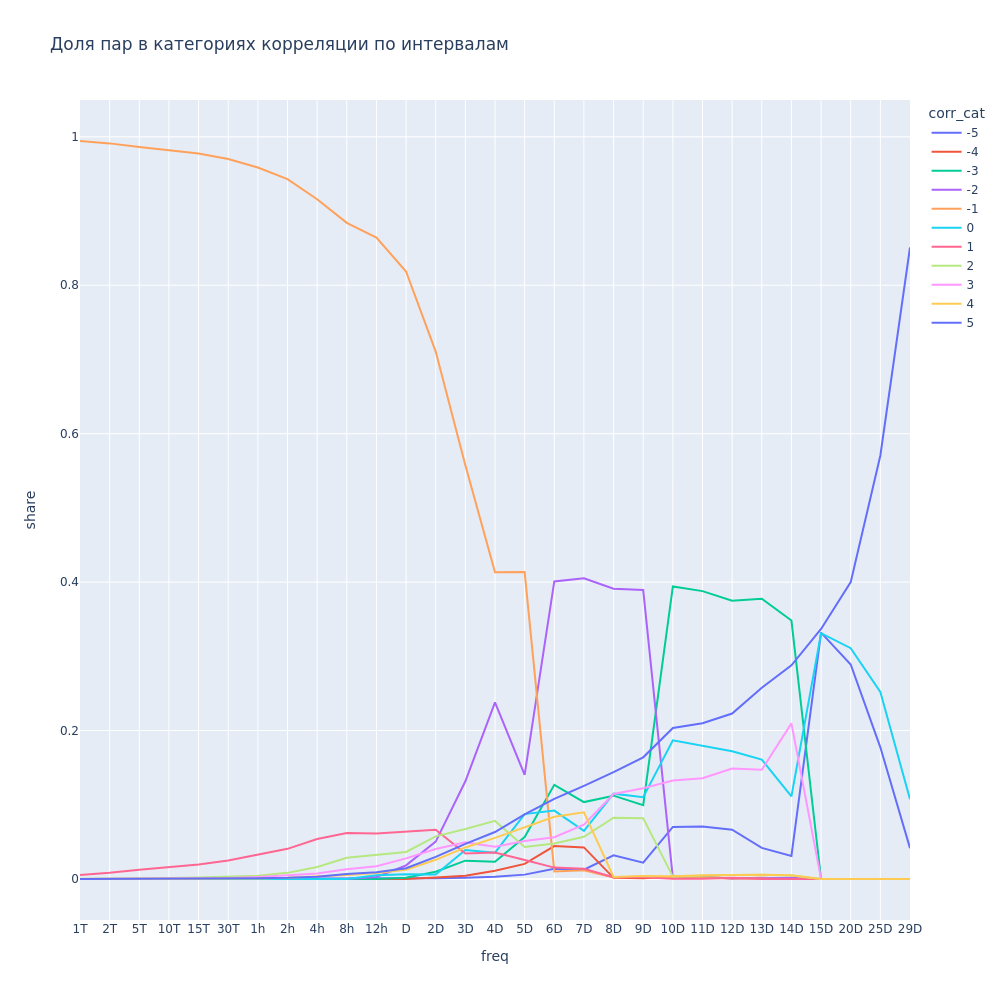

In [30]:
df_corr_cat = pd.DataFrame(list(range(-5, 6)))
import pandas as pd; import numpy as np
df_corr_cat.columns = [str(column) for column in df_corr_cat.columns]
# Step: Rename column
df_corr_cat = df_corr_cat.rename(columns={'0': 'corr_cat'})

df_i_full = pd.DataFrame()
for i in df_i.freq.unique():
    df_ = df_i.loc[df_i.freq == i].merge(df_corr_cat, on='corr_cat', how='right')
    df_.freq = i
    df_.cnt = df_.cnt.fillna(0)
    df_.share = df_.share.fillna(0)
    df_i_full = pd.concat([df_i_full, df_])
import plotly.express as px
fig = px.line(df_i_full, x='freq', y='share', color='corr_cat', title='Доля пар в категориях корреляции по интервалам')
fig

In [31]:
def corr_quant_share(freq):
    import pandas as pd; import numpy as np
    res = interval_corr_groups(freq)[1]
    corr_quant_share_ = []
    for i in range(-5, 6):
         corr_quant_share_.append(len(set(list(res.loc[res.corr_cat == i].name1)\
                                          + list(res.loc[res.corr_cat == i].name2))))
    corr_quant_share_ = pd.DataFrame(corr_quant_share_)
    import pandas as pd; import numpy as np
    corr_quant_share_.columns = [str(column) for column in corr_quant_share_.columns]
    # Step: Rename column
    corr_quant_share_ = corr_quant_share_.rename(columns={'0': 'cnt'})
    corr_quant_share_['corr_cat'] = list(range(-5, 6))
    corr_quant_share_['share'] = round(corr_quant_share_.cnt / df.query('mo == "2020-09-01"').from_id.nunique(), 8)
    corr_quant_share_['freq'] = freq
    return corr_quant_share_

1T took 3.5 seconds
2T took 2.6 seconds
5T took 2.04 seconds
10T took 1.87 seconds
15T took 1.9 seconds
30T took 1.75 seconds
1h took 1.74 seconds
2h took 1.78 seconds
4h took 1.65 seconds
8h took 1.7 seconds
12h took 1.71 seconds
D took 1.74 seconds
2D took 1.65 seconds
3D took 1.82 seconds
4D took 1.75 seconds
5D took 1.64 seconds
6D took 1.78 seconds
7D took 1.69 seconds
8D took 1.75 seconds
9D took 1.7 seconds
10D took 1.88 seconds
11D took 1.74 seconds
12D took 1.78 seconds
13D took 1.8 seconds
14D took 1.77 seconds
15D took 1.71 seconds
20D took 1.76 seconds
25D took 1.8 seconds
29D took 1.78 seconds


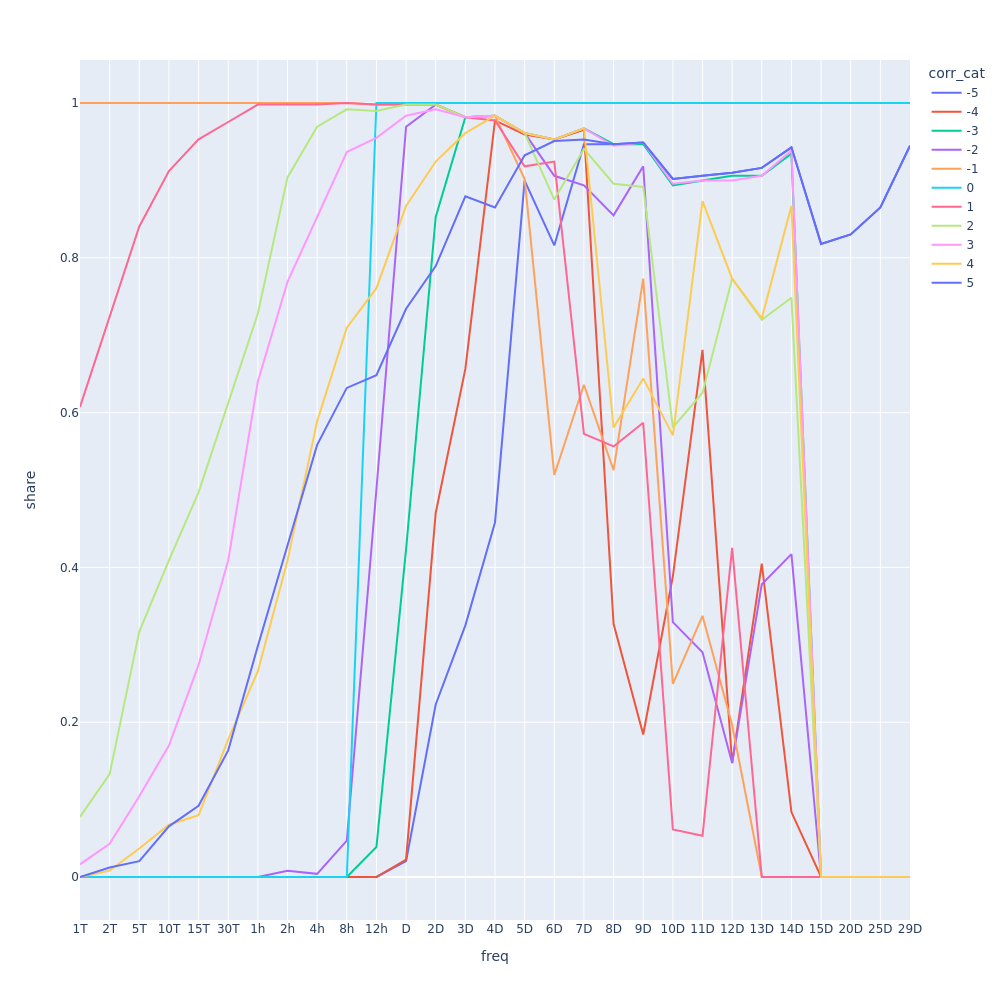

In [32]:
# intervals = []
# for i in range(1,81, 1):
#     intervals.append(str(i) + 'D')
intervals = ['1T', '2T', '5T', '10T', '15T', '30T', '1h', '2h', '4h', '8h', '12h', 'D', '2D', '3D', '4D',\
             '5D','6D', '7D', '8D', '9D', '10D', '11D', '12D', '13D', '14D', '15D',\
             '20D', '25D', '29D']
df_ = pd.DataFrame()
for i in intervals:
    start = time.time()
    df_ = pd.concat([df_, corr_quant_share(i)])
#     if int(i[:-1]) % 10 == 0:
        
    print(f'{i} took {round(time.time() - start, 2)} seconds')
df_

import plotly.express as px
fig = px.line(df_, x='freq', y='share', color='corr_cat')
fig

### **Вывод**

* Крайние корреляционные парные категории (-5 и 5) пересекаются в районе 7 дня и повторяют друг друга после этого периода

* По количеству вовлеченность почти всех активных пользователей, показавших какую-либо активность, происходит на 12-й час (100%).


## **Общий вывод**

***`Когортный анализ`***


* Архив содержит 537,318 записей о совершенных действиях
* Кол-во приглашенных за отчетный период – 32,494
* Кол-во когорт – 31
* Период анализа – 6 месяцев
* Средний уровень удержания на второй месяц оставляет 31,6%
* Все когорты имеют тенденцию снижения на второй месяц, некоторые - с небольшими всплесками уровня удержания порядка 2-5% в последующие месяцы
* Лучшая когорта с удержанием 52% на второй месяц стартовала в феврале 2022, худшая – с удержанием 16% - в августе 2020 года
* Имеются несколько когорт, наращивающие свое присутствие после второго месяца. Это: 2020-08, 2020-07, 2021-08, 2021-10, 2021-11, 2021-12, 2022-05, 2022-09, 2022-10
* Кумулятивный пик кол-ва сообщений когорт находится в сентябре 2020 и составляет порядка 102,000


***`Количественный анализ`***


* Среднее кол-во привлеченных пользователей составляет 377 в месяц, максимальное 2640 (2020-04), минимальное – 110 (2021-09)
Максимальный прирост кол-ва пользователей составляет 152% к предыдущему (2022-03), минимальный - -60% (2023-03). Средний прирост составляет 0% - активность группы стагнирует
Максимальное число активных пользователей – 2640 (2020-04), минимальное – 430 (2020-09), среднее – 1109

* Максимальное число сообщений – 28527 (2022-04), минимальное – 2607 (2021-09-01), среднее – 10884

* Максимальный прирост кол-ва сообщений составляет 222% к предыдущему (2022-03), минимальный - -62% (2022-05). Средний прирост составляет 0% - активность группы стагнирует
Кол-во сообщений в день по скользящему среднему за 7 дней составляет максимальное 1927 (2020-04), минимальное – 57 (2021-09), среднее – 361

* Максимальное кол-во сообщений в день на пользователя по скользящему среднему за 7 дней составляет 15 (2020-08), минимальное 1,67 (2020-08), среднее – 4

* Максимальное кол-во сообщений в месяц на пользователя составляет 31.79 (2020-08), минимальное 4.68 (2022-01), среднее – 10

* Максимальный прирост среднего кол-ва сообщений в месяц на пользователя составляет 117% к предыдущему (2020-08), минимальный - -56% (2022-05). Средний прирост составляет 0% - активность группы стагнирует


***`Анализ совместной активности пользователей`***




* Крайние корреляционные парные категории (-5 и 5) пересекаются в районе 7 дня и повторяют друг друга после этого периода

* По количеству вовлеченность почти всех активных пользователей, показавших какую-либо активность, происходит на 12-й час (100%).


***Примечание***

*данный анализ не имеет рекомендаций, так как проведен в целях общего изучения предмета и тренировки аналитических навыков*

*при анализе на любом промежутке, имеющем активных пользователей, показатели активности будут иметь приблизительно такое же распределение, масштабированное на отрезок анализа. при любом отрезке анализа при наличии активных пользователей происходит дробление пользователей на группы, которые находятся в отрицательной и положительной корреляции в какой-либо степени*